# Basic single channel LDDMM

In [2]:
import sys
sys.path.insert(0,'../') # add code directory to path
# import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt

## Load images as numpy arrays - Human Brain MRI

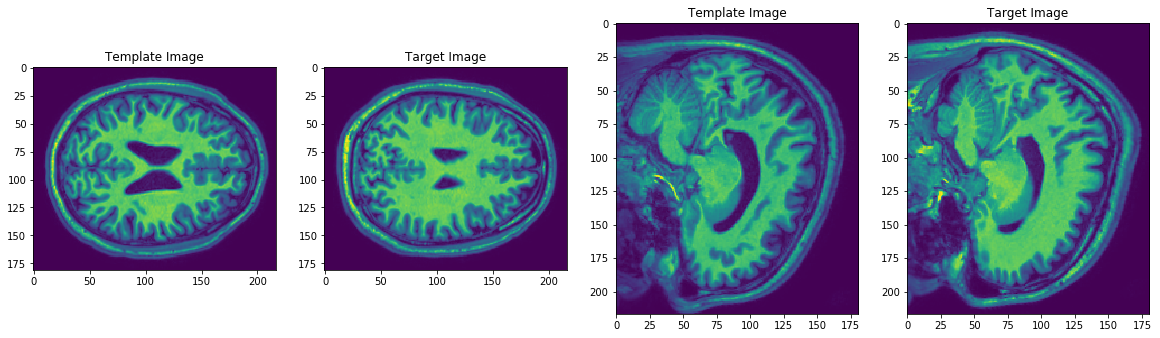

In [3]:
# set image file names
template_file_name = '../notebook/Adt27-55_02_Adt27-55_02_MNI.img'
target_file_name = '../notebook/Adt27-55_03_Adt27-55_03_MNI.img'

# load images
template_image_struct = nib.load(template_file_name)
target_image_struct = nib.load(target_file_name)

# set image spacing from template image, assume both images are the same spacing
dx = template_image_struct.header['pixdim'][1:4]

# get images as 3D numpy arrays
template_image = np.squeeze(template_image_struct.get_data()).astype(np.float32)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)

# draw a slice of each brain
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(template_image[:,:,100])
plt.title('Template Image')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(template_image[105,:,:])
plt.title('Template Image')
plt.subplot(1,4,4)
plt.imshow(target_image[105,:,:])
plt.title('Target Image')
plt.show()

## 3D LDDMM Image Registration

In [4]:
# create torch_lddmm object
# we manually set:
# 'a', the lddmm kernel size to 7 voxels
# 'niter', the number of iterations to 200
# 'epsilon', the gradient descent size to 4e0
# 'sigma' and 'sigmaR', the matching and regularization weights to 20 and 30
# 'optimizer' to 'gdr', gradient descent with reducing step size
lddmm = torch_lddmm.LDDMM(template=template_image,target=target_image,outdir='../notebook/',do_affine=0,do_lddmm=1,a=7,niter=200,epsilon=4e0,sigma=20.0,sigmaR=40.0,optimizer='gdr',dx=dx)


Current parameters:
>    a               = 7 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20.0 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CUDA_V

In [5]:
# now we run the computation. In the console output, ER indicates regularization energy, EM indicates image matching energy, and E is the sum of ER and EM
lddmm.run()

iter: 0, E = 11173544.0000, ER = 0.0000, EM = 11173544.0000, epd = 4.000000.
iter: 1, E= 9205924.000, ER= 3223.565, EM= 9202700.000, epd= 4.000, time= 0.78s.
iter: 2, E= 8627903.000, ER= 4701.123, EM= 8623202.000, epd= 4.000, time= 0.91s.
iter: 3, E= 8317782.500, ER= 7920.316, EM= 8309862.000, epd= 4.000, time= 0.90s.
iter: 4, E= 8135880.000, ER= 9763.195, EM= 8126117.000, epd= 4.000, time= 0.90s.
iter: 5, E= 8045732.500, ER= 12732.515, EM= 8033000.000, epd= 4.000, time= 0.90s.
iter: 6, E= 8034477.000, ER= 14607.955, EM= 8019869.000, epd= 4.000, time= 0.90s.
iter: 7, E= 8027186.500, ER= 17492.309, EM= 8009694.000, epd= 4.000, time= 0.90s.
iter: 8, E= 7676831.000, ER= 18399.779, EM= 7658431.000, epd= 2.800, time= 0.90s.
iter: 9, E= 7550306.500, ER= 20019.316, EM= 7530287.000, epd= 2.800, time= 0.90s.
iter: 10, E= 7476408.500, ER= 21502.451, EM= 7454906.000, epd= 2.800, time= 0.90s.
iter: 11, E= 7405194.500, ER= 23071.504, EM= 7382123.000, epd= 2.800, time= 0.90s.
iter: 12, E= 7351343.00

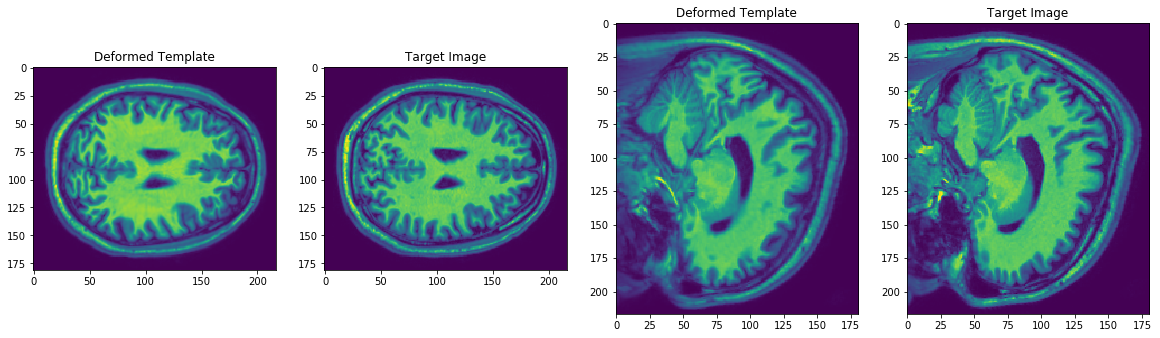

In [6]:
# display the deformed template according to the current transform
(deformed_template,_,_,_) = lddmm.applyThisTransform(template_image)
deformed_template = deformed_template[-1].cpu().numpy()
plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_template[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_template[105,:,:])
plt.title('Deformed Template')
plt.subplot(1,4,4)
plt.imshow(target_image[105,:,:])
plt.title('Target Image')
plt.show()

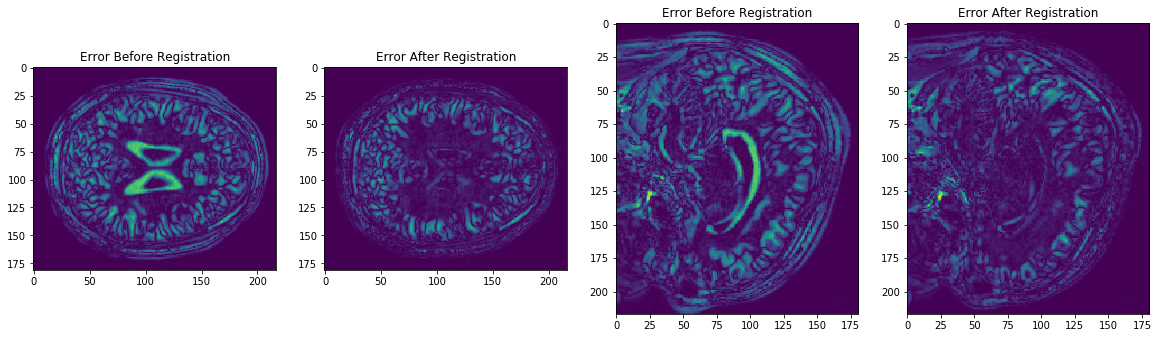

In [7]:
# display intensity difference before and after mapping
diffimg_before = np.abs(template_image-target_image)
diffimg_after = np.abs(deformed_template-target_image)
plt.figure()
plt.subplot(1,4,1)
plt.imshow(diffimg_before[:,:,100],vmin=0,vmax=255)
plt.title('Error Before Registration')
plt.subplot(1,4,2)
plt.imshow(diffimg_after[:,:,100],vmin=0,vmax=255)
plt.title('Error After Registration')
plt.subplot(1,4,3)
plt.imshow(diffimg_before[105,:,:],vmin=0,vmax=255)
plt.title('Error Before Registration')
plt.subplot(1,4,4)
plt.imshow(diffimg_after[105,:,:],vmin=0,vmax=255)
plt.title('Error After Registration')
plt.show()

In [8]:
# output transforms
(vt0,vt1,vt2) = lddmm.outputTransforms() # output LDDMM and linear transforms
(phi0,phi1,phi2) = lddmm.computeThisDisplacement() # output resultant displacement field
deformed_template = lddmm.outputDeformedTemplate() # output deformed template as numpy array

# clear memory (the LDDMM object still exists and consumes some GPU memory but transforms are deleted)
lddmm.delete()